In [1]:
from pprint import pprint
import sys, getopt
from prepare_problem import get_problem_data
import json 

In [2]:
from dimod import cqm_to_bqm, Binary, Integer, ConstrainedQuadraticModel
from dwave.system import LeapHybridBQMSampler, LeapHybridCQMSampler

import numpy as np
from parse import parse
from pprint import pprint
import time


import pickle
import os

In [4]:
inputfile = "workflows/pegasus-workflow.json"
machinefile = "cyfronet_machines.json" 

deadline = 10000

output_name = f"pickled_cqm_results/{os.path.splitext(inputfile)[0]}_{os.path.splitext(machinefile)[0]}_{deadline}.pkl"


In [36]:
with open(inputfile) as f:    
    pprint(len(json.loads(f.read())["workflow"]['jobs']))

22


In [100]:
with open(inputfile) as f:
    input = json.loads(f.read())

machines = None
if machinefile is not None:
    with open(machinefile) as f:
        machines = json.loads(f.read())

In [101]:
# def cqm_solution(cost_df, jobs, runtimes, paths, deadline, debug = False):
cost_df, runtimes, jobs, paths = get_problem_data(input, machines)

In [102]:

cqm = ConstrainedQuadraticModel()
xs = []
job_count = len(jobs)

for machines in range(len(cost_df.columns)):
    x = [Binary(f'm{machines}_x{i}') for i in range(job_count)]
    xs.extend(x)

# Problem definition
model = None
for cost, variable in zip(np.array(cost_df).flatten(), xs):
    if model:
        model = model + cost * variable
    else:
        model = cost * variable
cqm.set_objective(model)

# Must use exactly one machine
for i in range(job_count):
    one_machine = None
    for j in range(i, len(xs), job_count):
        if one_machine:
            one_machine = one_machine + xs[j]
        else:
            one_machine = xs[j]
    cqm.add_constraint( one_machine == 1)

# All paths finish before dedline 

flat_runtimes = [(runtime, name) for n, machine_runtimes in runtimes.items() for runtime, name in zip(machine_runtimes, [j.name for j in jobs])]

for path in paths:
    path_runtime = None
    for var, (runtime, name) in zip(xs, flat_runtimes):
        if name not in path:
            continue
        if path_runtime:
            path_runtime = path_runtime + runtime * var
        else:path_runtime = runtime * var
    cqm.add_constraint(path_runtime <= deadline)

sampler_cqm = LeapHybridCQMSampler()

start = time.time()
solution = sampler_cqm.sample_cqm(cqm,time_limit=5)
end = time.time()

In [103]:

# if debug:
#     pprint(solution.info)

def is_correct_solution(cqm, sol):
    return len(cqm.violations(sol, skip_satisfied = True)) == 0

correct_solutions = [ s for s in solution if is_correct_solution(cqm, s)]
# if debug:
#     pprint(solution.info)

best_solution = correct_solutions[0]

machine_names = cost_df.columns
job_names = cost_df.index

actual_solution = {}

for k, is_used in best_solution.items():
    machine, var = parse('m{}_x{}', k)
    if is_used:
        actual_solution[jobs[int(var)].name] = machine_names[int(machine)]

In [107]:
# for s in solution:
print(solution.data_vectors.keys())
print(solution.data_vectors["energy"])
print(solution.data_vectors["num_occurrences"])
print(solution.data_vectors["is_feasible"])
print(solution.data_vectors["is_satisfied"])
print(solution.info.keys())
print(solution.info['qpu_access_time'])

solved_cqm = {
    "input" : inputfile,
    "machines" : machines,
    "deadline" : deadline,
    "solution" : {
        "info" : solution.info,
        "data_vectors" : solution.data_vectors,
        "solutions" : [s for s in solution],
    },
    "machine_names" : machine_names,
    "job_names" : job_names
}

with open(output_name, 'wb') as out_file:
    pickle.dump(solved_cqm, out_file)


dict_keys(['energy', 'num_occurrences', 'is_feasible', 'is_satisfied'])
[483.98027513 490.14077699 479.64617626 406.38052515 309.60660804
 511.17358353 544.50950676 533.22094402 607.51385119 483.41053149
 300.50152282 485.59062012 478.53291354 441.20447174 615.72613387
 289.09855129 548.63069154 503.29375673 493.70536793 545.43535494
 534.80700547 515.77200225 544.50950676 541.79882736 610.77511644
 545.80088554 509.68134172 485.59062012 491.36965658 518.42695677
 615.72613387 547.34801917 545.80088554 464.50808979 331.09289821
 412.27480998 380.17093272 411.55612881 432.45792399 427.72005399
 399.43020399 542.78852692 435.40394718 451.88030812 446.89670133
 452.76851539 453.68954417 458.51430864 426.61554771 432.32113749]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[False False False False False False  True False False False False  True
 False False  True False  True  True  True  True  True  True  True  True
  True  True  True

In [7]:
with open(output_name, 'rb') as solution_file:
    solved_cqm = pickle.load(solution_file)


FileNotFoundError: [Errno 2] No such file or directory: 'pickled_cqm_results/workflows/pegasus-workflow_cyfronet_machines_10000.pkl'

In [43]:
samples = list(sorted(zip(solved_cqm["solution"]["data_vectors"]["energy"], solved_cqm["solution"]["data_vectors"]["is_feasible"])))
samples = list(sorted(solved_cqm["solution"]["data_vectors"]["energy"]))
samples

correct_solutions = [e for i,e in enumerate(solved_cqm["solution"]["data_vectors"]["energy"]) if solved_cqm["solution"]["data_vectors"]["is_feasible"][i]]
incorrect_solutions = [e for i,e in enumerate(solved_cqm["solution"]["data_vectors"]["energy"]) if not solved_cqm["solution"]["data_vectors"]["is_feasible"][i]]

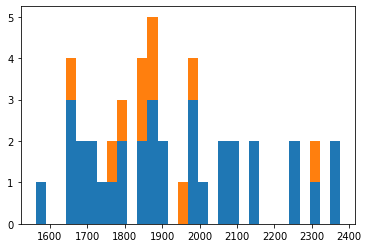

In [47]:
import matplotlib.pyplot as plt
plt.hist([correct_solutions, incorrect_solutions], bins=30, stacked=True)

plt.show()

In [3]:
import matplotlib.pyplot as plt

def plot_energy_histogram(output_name):
    with open(output_name, 'rb') as solution_file:
        solved_cqm = pickle.load(solution_file)
    samples = list(sorted(zip(solved_cqm["solution"]["data_vectors"]["energy"], solved_cqm["solution"]["data_vectors"]["is_feasible"])))
    samples = list(sorted(solved_cqm["solution"]["data_vectors"]["energy"]))
    samples

    correct_solutions = [e for i,e in enumerate(solved_cqm["solution"]["data_vectors"]["energy"]) if solved_cqm["solution"]["data_vectors"]["is_feasible"][i]]
    incorrect_solutions = [e for i,e in enumerate(solved_cqm["solution"]["data_vectors"]["energy"]) if not solved_cqm["solution"]["data_vectors"]["is_feasible"][i]]

    plt.rcParams["figure.figsize"] = (6,4)
    plt.hist([correct_solutions, incorrect_solutions], bins=30, stacked=True, label=["Correct", "Incorrect"])
    plt.title(output_name)
    plt.xlabel("Energy of the solution")
    plt.ylabel("Number of returned solution in buckets")
    plt.legend()
    plt.grid()
    # plt.show()
    plt.savefig(f"plots/{os.path.basename(os.path.splitext(output_name)[0])}.pdf")
    plt.show()

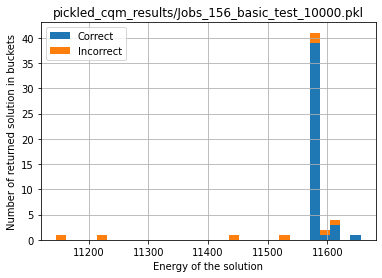

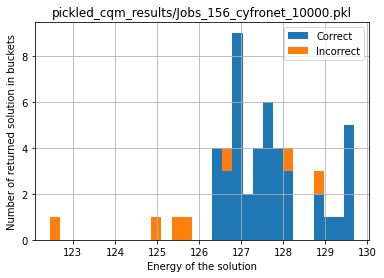

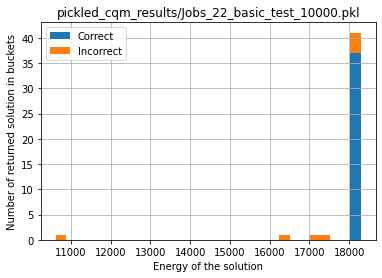

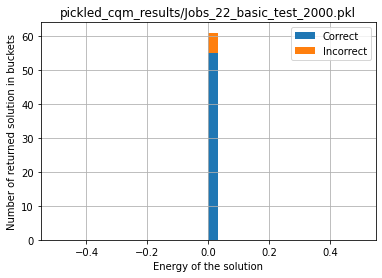

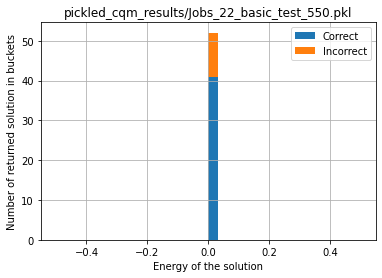

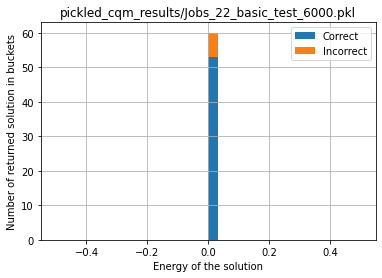

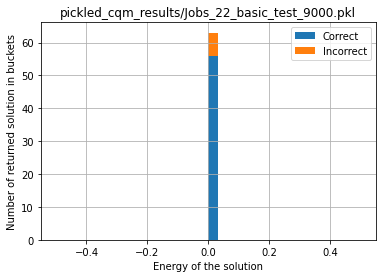

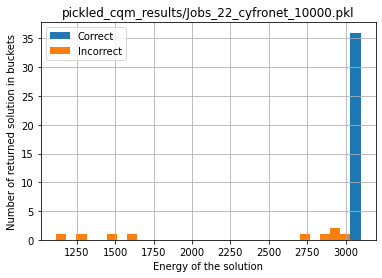

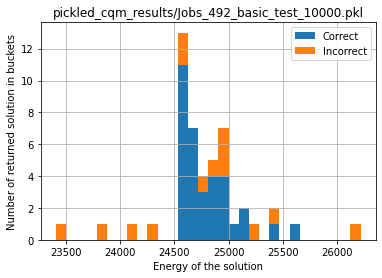

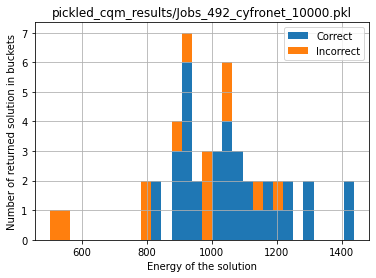

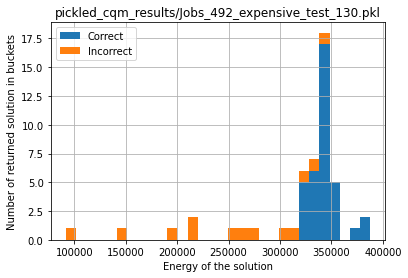

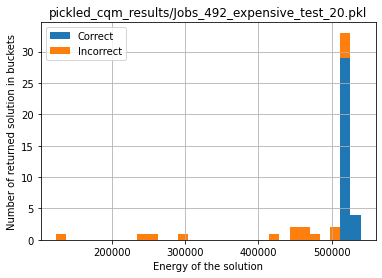

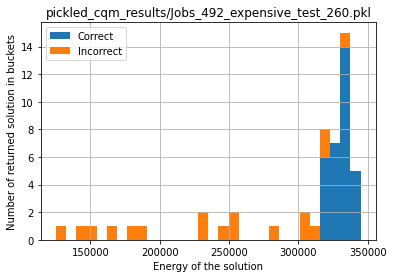

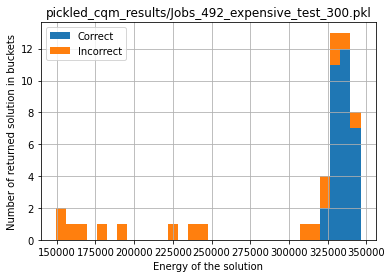

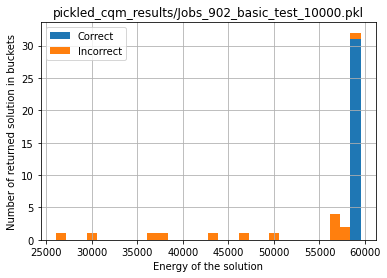

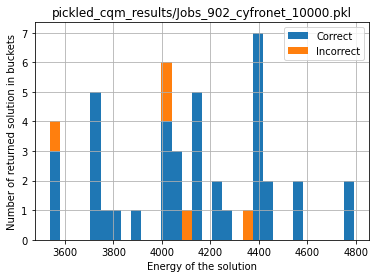

In [9]:
from os import walk

histograms = next(walk("pickled_cqm_results"), (None, None, []))[2]  # [] if no file
for histogram in histograms:
    # if "expensive" in histogram:
        plot_energy_histogram(f"pickled_cqm_results/{histogram}")